In [17]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.Spectroscopy import Spectrum
from scipy.optimize import curve_fit
from LowLevelModules.GeneralFunctions import get_work_dir, prettify_plot, prettify_2d_plot, voigt_func, voigt_func_2p
import numpy as np
import os
# user input
wdir = r'Z:\Projects\WSe2\2019\10 october\2019-10-08 WSe2 on gatedNP\RT data\Vscan'
keyword = 'on_pillar'
## fetch all SPE files in folder
files = [f for f in os.listdir(wdir) if '.spe' in f]
filenames = [f[:-4] for f in files if not 'raw' in f]
filenames = [f for f in filenames if keyword in f]
# extract voltage param
idx = filenames[0].find(keyword)
voltage = [float(f[idx + len(keyword):-1]) for f in filenames]
#sort filenames ascending
filenames = [f for _, f in sorted(zip(voltage,filenames))]
voltage.sort()

In [2]:
import ipywidgets as widgets
from IPython.display import display
normalize_choice = widgets.Checkbox(
    value=False,
    description='Normalize and shift',
    disabled=False
)

etaloning_choice = widgets.Checkbox(
    value=True,
    description='Remove CCD etaloning',
    disabled=False
)
fit_choice = widgets.Checkbox(
    value=False,
    description='Fit data with 2 Voigt profiles',
    disabled=False
)

x_axis_choice = widgets.RadioButtons(
    options=['Wavelength (nm)', 'Energy (eV)'],
    value='Wavelength (nm)',
    description='X axis unit:',
    disabled=False
)
display(etaloning_choice)
display(normalize_choice)
display(fit_choice)
display(x_axis_choice)

Checkbox(value=True, description='Remove CCD etaloning')

Checkbox(value=False, description='Normalize and shift')

Checkbox(value=False, description='Fit data with 2 Voigt profiles')

RadioButtons(description='X axis unit:', options=('Wavelength (nm)', 'Energy (eV)'), value='Wavelength (nm)')

<IPython.core.display.Javascript object>


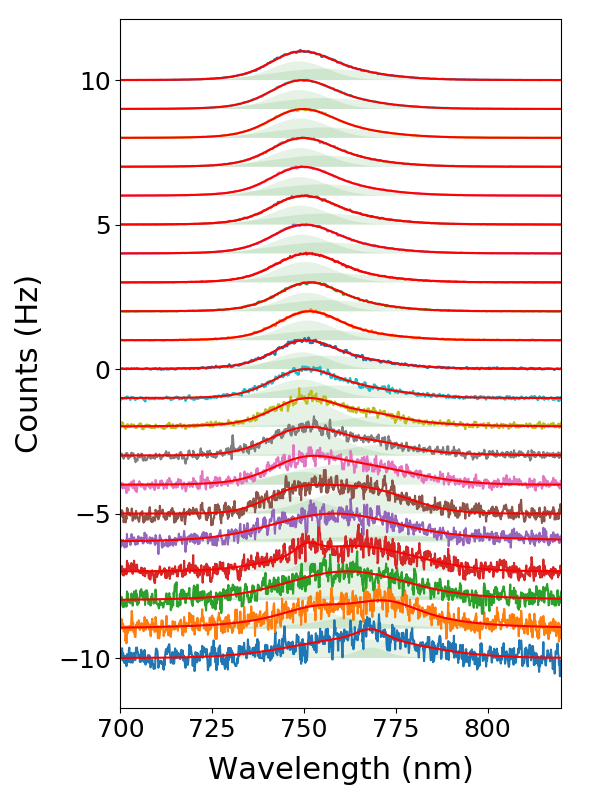

..\LowLevelModules\GeneralFunctions.py:196: RuntimeWarning: invalid value encountered in multiply
  arg1 = np.exp(-z1 ** 2) * (1 - erf(-1j * z1))
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


[  0.86653667 768.3769581 ] [  1.55458135 764.59421492]


..\LowLevelModules\GeneralFunctions.py:196: RuntimeWarning: overflow encountered in exp
  arg1 = np.exp(-z1 ** 2) * (1 - erf(-1j * z1))
..\LowLevelModules\GeneralFunctions.py:197: RuntimeWarning: invalid value encountered in multiply
  arg2 = np.exp(-z2 ** 2) * (1 - erf(-1j * z2))


[  1.95540681 772.65336813] [  1.38042628 752.86740879]
[3.88223515e-01 7.70759284e+02] [  2.29381331 761.45414052]
[  0.91449429 750.78294173] [  2.57094842 763.0202568 ]
[7.52206849e-01 7.77062470e+02] [  2.89087783 757.28457764]
[  3.20727779 765.46815574] [  2.15585924 747.21964352]
[  3.49114642 762.12108206] [  2.18852339 749.34866452]
[  6.30148058 750.65662235] [  2.69348938 771.10241584]
[  9.47532207 750.52287524] [  3.91404303 769.13991689]
[  7.19946447 758.76117398] [ 10.52552324 749.28115071]
[ 20.4515058  749.34459454] [ 16.40505236 756.31428527]
[ 30.20520045 756.34786435] [ 61.08268478 750.92520751]
[ 50.56593804 756.08577384] [ 84.05993106 750.83264135]
[119.69751156 750.34521611] [ 54.68561298 756.59443288]
[135.7658869  749.37587354] [ 80.37338205 755.64075161]
[ 94.91227209 755.57290595] [164.42993545 749.06496213]
[106.54641168 755.04069213] [174.40419073 748.82769287]
[185.62864286 748.82614438] [110.75750241 755.21718241]
[106.06380594 755.63781957] [197.9537275

In [19]:
def normalize_data(yy, v_shift = 0):
    return yy / np.max(yy) + v_shift

#select_file = filenames[10:]
# fitting bounds on two peaks a01, x01, sigma1, gamma1, a02, x02, sigma2, gamma2
bds = ([.1, 700, 0.1, 0.1, 0.1, 700, 0.1, 0.1],[np.inf, 800, 50, 50, np.inf, 800, 50, 50])
v_spacing = 1
#plot
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111)
cts = np.zeros(1340,)
peak1, peak2 = [], []
nd_counts = []   # for the 2d voltage/spectra plot
for i, f in enumerate(filenames):
    # plot everything
    file = wdir + '\\' + f + '.spe'
    data = Spectrum(file)
    data.remove_cosmic_ray(5)
    data.y -= np.mean(data.y[:30])
    if etaloning_choice.value:
        data.remove_etaloning(0.28, 0.46, 0.02, plotplot=False)
    if x_axis_choice.value == 'Energy (eV)':
        data.x = 1241/data.x
        data.x = data.x[::-1]
        data.y = data.y[::-1]
    nd_counts.append(data.y)
    
    if fit_choice.value:
        try:
            coeffs = []
            coeffs, _ = curve_fit(voigt_func_2p, data.x, data.y, bounds=bds)
            #sort peaks
            pk1 = coeffs[0:2]
            pk2 = coeffs[4:6]
            print(pk1, pk2)
            if pk1[1] > pk2[1]:
                pk2, pk1 = pk1, pk2
            peak1.append(pk1)
            peak2.append(pk2)
            y_arrf = voigt_func_2p(data.x, *coeffs)
            y_arr1 = voigt_func(data.x, *coeffs[:4])
            y_arr2 = voigt_func(data.x, *coeffs[4:])
            max_spec = np.max(y_arrf)

        except ValueError:
            peak1.append([np.nan, np.nan])
            peak2.append([np.nan, np.nan])
            print('Fit not converging for V = ', voltage[i])
    #plot
    if normalize_choice.value:
        data.y = data.y / max_spec + voltage[i] # + i*v_spacing
    
    ax.plot(data.x, data.y, '-')  
    if fit_choice.value:
        if normalize_choice.value:
            y_arrf = y_arrf / max_spec + voltage[i] # + i*v_spacing
            y_arr1 = y_arr1 / max_spec + voltage[i] # + i*v_spacing
            y_arr2 = y_arr2 / max_spec + voltage[i] # + i*v_spacing
        ax.plot(data.x, y_arrf, 'r')
        ax.fill(data.x, y_arr1, 'g', facecolor='green', alpha=0.1)
        ax.fill(data.x, y_arr2, 'g', facecolor='green', alpha=0.1)

            

#axis limits
#plt.xlim(data.x[0], data.x[-1])
#plt.ylim(0, 1.05*np.max(data.y))
#special cases
plt.xlim(700, 820)
#plt.ylim(0, 3)

#legend
#ax.legend(volts, prop={'size': 18})
prettify_plot(ax, x_axis_choice.value, "Counts (Hz)")
fig.tight_layout()

In [6]:
fig.savefig(wdir + '\\' + f + x_axis_choice.value[:-4] + '.png', format='png', bbox_inches='tight')

<IPython.core.display.Javascript object>


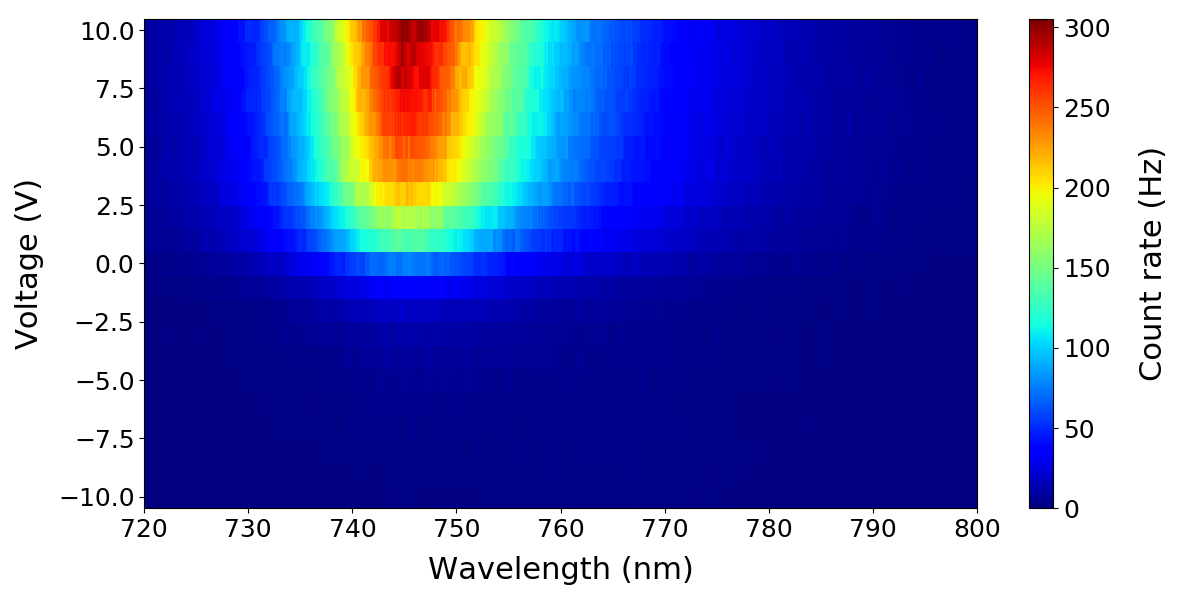

In [7]:
# plot spectral voltage scan in 2D
from matplotlib.colors import LogNorm
x = data.x
#shifts the data to make plot correct
dx = x[1]-x[0]
x = np.append(x - dx/2, x[-1] + dx/2)
y = np.array(voltage)
#shifts the data to make plot correct
dy = y[1]-y[0]
y = np.append(y - dy/2, y[-1] + dy/2)
z = np.array(nd_counts)

fig2 = plt.figure(figsize=(12,6))
ax2 = fig2.add_subplot(111)
p2 = ax2.pcolor(x, y, z, cmap='jet', vmin=0, vmax=np.max(z)) #norm=LogNorm(vmin=0, vmax=np.max(z))) #
cb2 = fig2.colorbar(p2)
prettify_2d_plot(ax2, cb2, x_axis_choice.value, 'Voltage (V)', 'Count rate (Hz)')
if x_axis_choice.value == 'Energy (eV)':
    plt.xlim(1.6, 1.8)
else:
    plt.xlim(720, 800)
#ax2.set_xticks([1.6, 1.65, 1.7, 1.75, 1.8])
fig2.tight_layout()

In [15]:
fig2.savefig(wdir + '\\' + f + '2dVoltagescan' + x_axis_choice.value[:-4] +'.png', format='png', bbox_inches='tight')

<IPython.core.display.Javascript object>


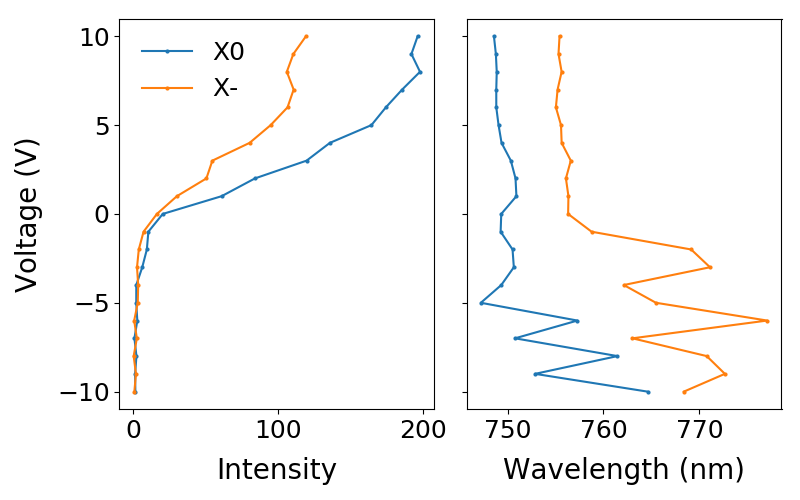

In [20]:
fig3, [ax31, ax32] = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
# fig3 = plt.figure(figsize=(8,5))
# ax31 = fig3.add_subplot(121)
# ax32 = fig3.add_subplot(122, sharey=ax31)
peak1 = np.array(peak1)
peak2 = np.array(peak2)

ax31.plot(peak1[:,0], voltage, 'o-', markersize=2)
ax31.plot(peak2[:,0], voltage, 'o-', markersize=2)

ax32.plot(peak1[:,1], voltage, 'o-', markersize=2)
ax32.plot(peak2[:,1], voltage, 'o-', markersize=2)

ax31.legend(['X0', 'X-'], prop={'size': 18}, frameon=False)
ax31.set_xlabel('Intensity', labelpad=10, fontsize=20)
ax32.set_xlabel('Wavelength (nm)', labelpad=10, fontsize=20)
ax31.set_ylabel('Voltage (V)', labelpad=10, fontsize=20)
ax31.tick_params(axis='both', labelsize=18)
ax32.tick_params(axis='both', labelsize=18)
fig3.tight_layout()

<IPython.core.display.Javascript object>


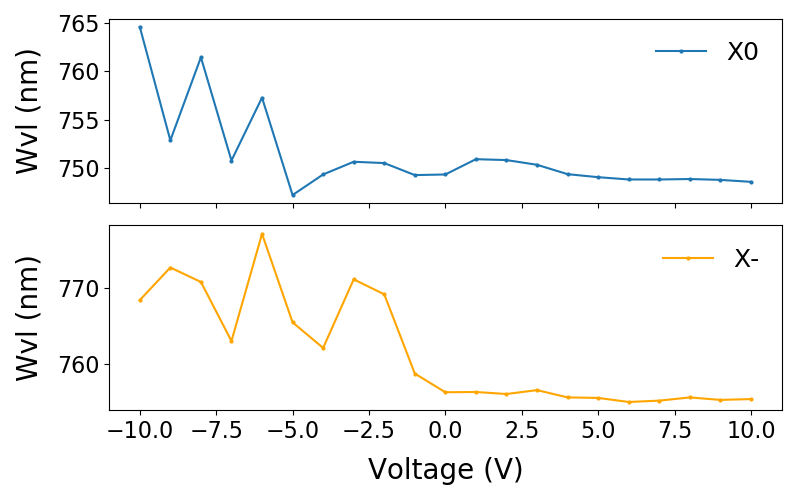

In [21]:
fig4, [ax41, ax42] = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
peak1 = np.array(peak1)
peak2 = np.array(peak2)

ax41.plot(voltage, peak1[:,1], 'o-', markersize=2)
ax42.plot(voltage, peak2[:,1], 'o-', color='orange', markersize=2)
ax41.legend(['X0'], prop={'size': 18}, frameon=False)
ax42.legend(['X-'], prop={'size': 18}, frameon=False)
ax41.set_ylabel('Wvl (nm)', labelpad=10, fontsize=20)
ax42.set_ylabel('Wvl (nm)', labelpad=10, fontsize=20)
ax42.set_xlabel('Voltage (V)', labelpad=10, fontsize=20)

ax41.tick_params(axis='both', labelsize=16)
ax42.tick_params(axis='both', labelsize=16)
fig4.tight_layout()

In [3]:
voltage

[-5.0,
 -4.5,
 -4.0,
 -3.5,
 -3.0,
 -2.5,
 -2.0,
 -1.5,
 -1.0,
 -0.5,
 0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5]